## Purpose
Validate the structure of data especially the comments for which I was unable to find data dictionary and had to validate guesses about its structure.

### Options:
* Use categories from semtype tagging to identify

## Initialize

In [2]:
# Utility
import sys,os
import time

import pandas as pd
import numpy as np

# Plotting
from ggplot import *
pd.set_option('display.max_columns', 500) # more columns displayed at once
pd.options.display.max_colwidth = 200 # more of the text displayed at once

# Custom
from processing import tag_utterances
from processing import load_sem_types
from processing import DataPipeline

# Set path for importing data
data_instance = DataPipeline(comments_path = '../data/reddit_comments_askDocs_2014_to_2018_03.gz',
                            posts_path = '../data/original_posts_under_askDocs_subreddit_id.gz')

## NLP
import spacy

In [4]:
path_to_data = '../data/reddit_comments_askDocs_2014_to_2018_03.gz'
df = pd.read_csv(path_to_data,dtype={'body':str,'score_hidden':float},low_memory=False)
print('Shape',df.shape)
df.head(2)

Shape (557648, 21)


,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,parent_id,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,removal_reason
0,"for a manlet such as yourself I'd recommend at least 70 oz of water daily and at least 7 hours of sleep. Cut down on red meat, smoking, and sodium intake and check back in a few days.",1.0,NaN,NaN,-Ai,This user has not yet been verified.,NaN,1513411674,t5_2xtuc,t3_7k5x2h,t3_7k5x2h,0,1.514772e+09,0,0,drbt2db,AskDocs,NaN,NaN,default,NaN
1,Thank you very much for answering!,1.0,NaN,NaN,-SY,This user has not yet been verified.,NaN,1445798103,t5_2xtuc,t3_3q697b,t1_cwcf958,2,1.447190e+09,0,0,cwcfjpr,AskDocs,2.0,NaN,default,NaN


**Using ETL Loaded Functions**

In [5]:
df = data_instance.load_full_thread()
import numpy as np
print('Turns in conversation for combined posts')
v = df['link_id_short'].value_counts().values
print('mean:', np.mean(v))
print('median:', np.median(v) )
print('min:',min(v))
print('max:',max(v))
print('Count of where turns equals 2:',sum(v==2))

Comments Table Shape: (557648, 24)
Posts table shape: (43615, 35)
30710
Final combined table shape: (139535, 28)
Turns in conversation for combined posts
mean: 4.543633995441224
median: 4.0
min: 2
max: 106
Count of where turns equals 2: 7843


In [6]:
df_counts = pd.DataFrame(df['link_id_short'].value_counts())
df_counts.columns = ['counts']
df_counts.head()

,counts
2nexj3,106
37o1az,84
3e4qbd,81
3hg7cq,63
2efaaz,56


In [18]:
med_percent = df[df['author_flair_text'] == 'This user has not yet been verified.'].shape[0] / df.shape[0]
print('Number of medical medical professionals:',len(df[df['author_flair_text'] == 'This user has not yet been verified.']['author'].unique()))
print('Percentage of posts by medical professionals: {}'.format(round(med_percent,3) * 100))

Percentage of posts by medical professionals: 49.0
Number of medical medical professionals: 16315


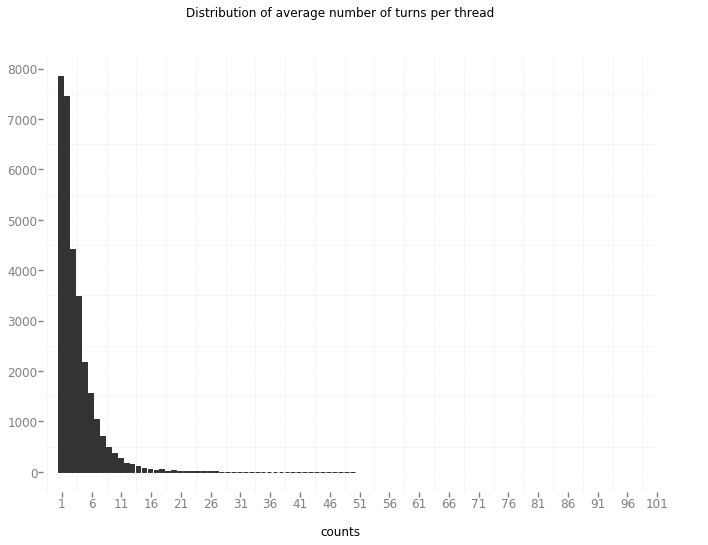

<ggplot: (371461538)>

In [202]:
breaks = [r for r in range(1,max(df_counts['counts']),5)]
ggplot(df_counts, aes(x='counts')) +\
    geom_bar() + \
    ggtitle('Distribution of average number of turns per thread') +\
    theme_bw() + scale_x_discrete(breaks = breaks,labels=breaks)

In [193]:
# Get number of words for all entries that started a thread
t = df[df['is_thread_start']==1].apply(lambda row: (len(str(row['body']).split()),row['link_id_short']),axis=1).tolist()
t_dict = {}
for entry in t:
    t_dict[entry[1]] = {'initial_len':entry[0]}

# Get the number of entries (counting thread start) per thread
unique_ids = set(df['link_id_short'])
for thread in unique_ids:
    count = df[df['link_id_short'] == thread].shape[0]
    t_dict[thread]['count'] = count

# Extract values
x = [] 
y = []
keys = t_dict.keys()
for k in keys:
    x.append(t_dict[k]['count'])
    y.append(t_dict[k]['initial_len'])

df_test = pd.DataFrame(np.column_stack([x,y]),columns=['count','# words thread start'])

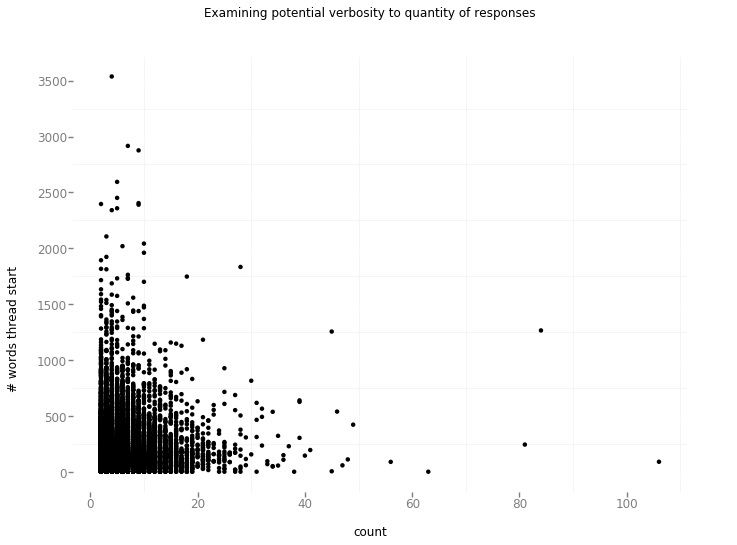

<ggplot: (-9223372036483300138)>

In [200]:
ggplot(df_test,aes(x='count',y='# words thread start')) + geom_jitter() + theme_bw() + ggtitle("Examining potential verbosity to quantity of responses")

In [85]:
thread_start_count = df[df['is_thread_start']==1]['body'].apply(lambda r: len(str(r).split()))
print('Mean num words for thread start:',np.mean(thread_start_count))
nonthread_start_count = df[df['is_thread_start']==0]['body'].apply(lambda r: len(str(r).split()))
print('Mean num words for non-thread start:',np.mean(nonthread_start_count))

Mean num words for thread start: 170.70797785737545
Mean num words for non-thread start: 47.11861245118309


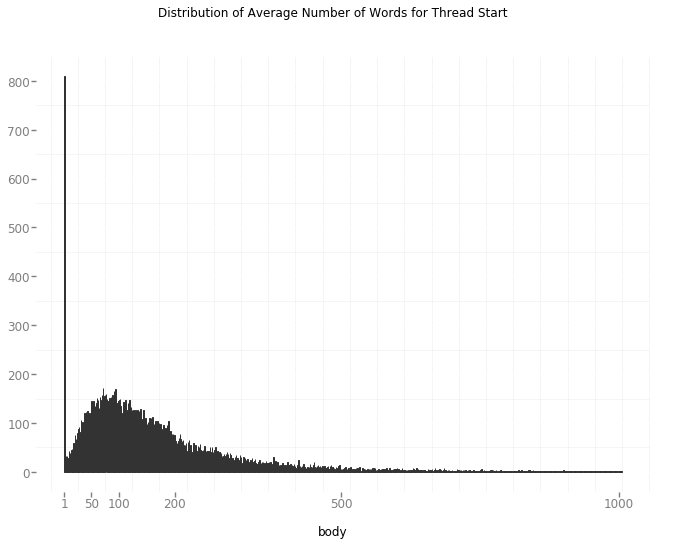

<ggplot: (368557874)>

In [197]:
df_start = pd.DataFrame(thread_start_count)
breaks = [1,50,100,200,500,1000]
ggplot(df_start, aes(x='body')) +\
    geom_bar() + \
    ggtitle('Distribution of Average Number of Words for Thread Start') +\
    theme_bw() + scale_x_discrete(breaks = breaks ,labels=breaks)

In [14]:
print('Number of users',len(set(df['author'])))
print('Global mean number of posts per user',len(df)/len(set(df['author'])))

Number of users 26353
Global mean number of posts per user 5.294843091868098


In [ ]:
df

In [13]:
df.shape

(139535, 28)

**Histogram of utterances lengths**

In [ ]:
utterance_lengths = df['body'].apply(lambda c: len(str(c)))
df_lengths = pd.DataFrame(utterance_lengths)

In [ ]:
ggplot(df_lengths,aes(x='body')) + geom_histogram() +theme_bw()

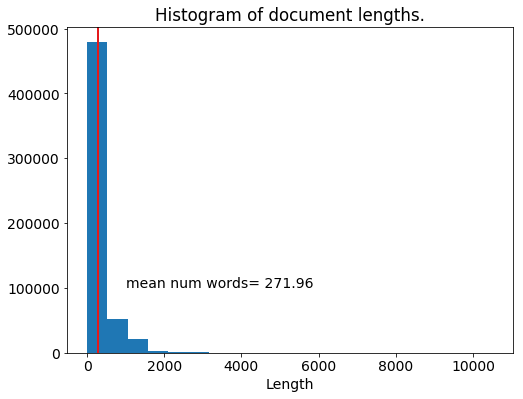

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

# Document lengths.
lens = utterance_lengths

# Plot.
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=14)
plt.rc('lines', linewidth=2)
plt.rc('axes')
# Histogram.
plt.hist(lens, bins=20)

# Average length.
avg_len = sum(lens) / float(len(lens))
plt.axvline(avg_len, color='#e41a1c')
plt.title('Histogram of document lengths.')
plt.xlabel('Length')
plt.text(1020, 100800, 'mean num words= %.2f' % avg_len)
plt.show()


## Data Dictionary:
Original post can be seen with the link_id
* **link_id** Link to the page where the original thread was started
    * **id** A posts id. The only reason this may not be unique
    * **parent_id** These ids are pointing back towards the original post and represent a new comment that is replying directly towards the original posting. Can be considered a general comment. I.e. All posts with the same parent_id (following the "_") as the link_id are. E.g. If the link_id is "t3_827pgt", all parent_id's with "827pgt" are pointing towards that original post.

* **subreddit_id** and **subreddit** Irrelevant


### Documentation:
* Figuring out how to organize a reply and response is tricky:
    * On one hand, the people asking the questions should be the non-clinician folks and the clinicians answering the questions. But it is a community forum so people can chime in with ''answers'' whenever. Ansd they might be correct.
     *  Also, it is likely that clinicians will ask follow-up questions if it is more debate than answer so perhaps drilling down into a solution
     * This latest point gets at how to utilize the id's and parent_ids
     
* <b>There are 2 reasonably straightforward ways of getting to the reply/response//question/answer pairs:</b>
    * 1) Treat each main post as the 1 question (then randomly select 1 response or have each comment in that thread be a response to the same question repeated for each response
    * 2) Treat each id (starting with the original thread) as the question and each subsequent post that has that id as its parent (**i.e. parent_id**)

In [ ]:
print('Number of rows:',df.shape[0])
print('Number of unique posters:',len(df.author.unique()))
print()
print('Number of link_ids:',len(df.link_id.unique()))
print('Number of parent_ids:',len(df.parent_id.unique()))
print('Number of ids:',len(df.id.unique()))

In [ ]:
print('Proportion of unique links to num rows:',len(df['link_id'].unique())/df.shape[0])
print('Proportion of unique ids to num rows:',len(df['id'].unique())/df.shape[0])
print('Proportion of unique parent ids to num rows:',len(df['parent_id'].unique())/df.shape[0])

## Medical Entity Extraction with UMLS

In [2]:
import sys
# UMLS
# Set absolute path the QuickUMLS Server
abs_path_umls = '/Users/austinpowell/Google_Drive/kp_datascience/doctor_notes/ontology/UMLS'
abs_path_data_umls = '/Users/austinpowell/Google_Drive/kp_datascience/doctor_notes/ontology/UMLS/QuickUMLS_db'
sys.path.append(abs_path_umls+'/QuickUMLS')
from quickumls import QuickUMLS
tagger = QuickUMLS(abs_path_data_umls)

In [3]:
# Load semantic types
sem_type_dict = load_sem_types('../data/SemGroups_2013.txt')

In [4]:
t = tagger.nlp(df['body'].iloc[4])
t.text

"She's had it for 8 months, we've never had any issues with it before."

In [7]:
t = tagger.nlp(t.text)

s = t
matches= tagger.match(s, best_match=True, ignore_syntax=False)
for match in matches:
    dir(match)
    print(match,'\n')
for m in match:
    print(m)

[{'start': 19, 'end': 25, 'ngram': 'months', 'term': 'month', 'cui': 'C1561542', 'similarity': 0.75, 'semtypes': {'T170'}, 'preferred': 1}] 

[{'start': 47, 'end': 53, 'ngram': 'issues', 'term': 'issue', 'cui': 'C0033213', 'similarity': 0.75, 'semtypes': {'T033'}, 'preferred': 1}, {'start': 47, 'end': 53, 'ngram': 'issues', 'term': 'issue', 'cui': 'C1706387', 'similarity': 0.75, 'semtypes': {'T170'}, 'preferred': 1}] 

{'start': 47, 'end': 53, 'ngram': 'issues', 'term': 'issue', 'cui': 'C0033213', 'similarity': 0.75, 'semtypes': {'T033'}, 'preferred': 1}
{'start': 47, 'end': 53, 'ngram': 'issues', 'term': 'issue', 'cui': 'C1706387', 'similarity': 0.75, 'semtypes': {'T170'}, 'preferred': 1}


In [ ]:
sd = load_sem_types('../data/SemGroups_2013.txt')

In [11]:
import importlib
from processing import tag_utterances
from processing import load_sem_types

tag_utterances(1, t.text, tagger)

{'T170'}


[[1, 19, 25, 'month', 'C1561542', 0.75, {'Intellectual Product'}]]

In [8]:
df.shape

(557648, 21)

In [ ]:
%%time
print('Iterating over every document')
#Iterate over every document and extract the concepts
i=-1        
result = []
for idx,doc in  enumerate(df['body']):

    if idx % 10000 == 0:
        print("Documents processed: {}".format(idx))
    try:
        i+=1
        annotations = tag_utterances(i,doc,tagger)
        result.extend(annotations)
    except Exception as e:
        print(e)
        
df_matches = pd.DataFrame(data=result, columns =['document','start','end','term','cui','similarity','semtypes'])
df_matches.sort_values(by=['document','start'],inplace=True)

In [6]:
df.head()

,body,score_hidden,archived,name,author,author_flair_text,downs,created_utc,subreddit_id,link_id,...,score,retrieved_on,controversiality,gilded,id,subreddit,ups,distinguished,author_flair_css_class,removal_reason
0,for a manlet such as yourself I'd recommend at...,NaN,NaN,NaN,-Ai,This user has not yet been verified.,NaN,1513411674,t5_2xtuc,t3_7k5x2h,...,0,1.514772e+09,0,0,drbt2db,AskDocs,NaN,NaN,default,NaN
1,Thank you very much for answering!,NaN,NaN,NaN,-SY,This user has not yet been verified.,NaN,1445798103,t5_2xtuc,t3_3q697b,...,2,1.447190e+09,0,0,cwcfjpr,AskDocs,2.0,NaN,default,NaN
2,Never been tested for that. I was hoping the ...,NaN,NaN,NaN,-o2,This user has not yet been verified.,NaN,1461952470,t5_2xtuc,t3_4gz1fi,...,1,1.463777e+09,0,0,d2mce34,AskDocs,1.0,NaN,default,NaN
3,"She said her constant abdominal pain is a 6, t...",NaN,NaN,NaN,05P,This user has not yet been verified.,NaN,1504214332,t5_2xtuc,t3_6x9jk0,...,1,1.504553e+09,0,0,dme9lzr,AskDocs,NaN,NaN,default,NaN
4,"She's had it for 8 months, we've never had any...",NaN,NaN,NaN,05P,This user has not yet been verified.,NaN,1504217835,t5_2xtuc,t3_6x9jk0,...,1,1.504554e+09,0,0,dmecohs,AskDocs,NaN,NaN,default,NaN


### Data Journal

* **Creating training data**
    * A lot of decisions have to be made when creating the conversational data. We could just give line by line
    * Even deciding what an utterance is can be difficult. Is it split by sentence? Do we assume that people are going to be generally giving one answer?
    * Should the title or actual post be used as the query?